# Exploratory Data Analysis

In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import random
import scipy.io as sio

In [97]:
IMG1 = os.path.join("dataset", "lizard_images1", "Lizard_Images1")
IMG2 = os.path.join("dataset", "lizard_images2", "Lizard_Images2")
LABELS = os.path.join("dataset", "lizard_labels", "Lizard_Labels", "Labels")
INFO = os.path.join("dataset", "lizard_labels", "Lizard_Labels", "info.csv")
OVERLAY = os.path.join("dataset", "overlay", "Overlay")

In [101]:
# info.csv
df = pd.read_csv(INFO)
df.head()

,Filename,Source,Split
0,dpath_1,1800127001_2019-04-30 10_40_02-lv1-1001-22444-...,3
1,dpath_2,1902160001_2019-06-11 12_36_32-lv1-39045-16016...,2
2,dpath_3,2019_03867_1-1_2019-02-20 20_00_32-lv1-35269-3...,3
3,dpath_4,2019-07501-1-1-1_2019-05-29 08_22_25-lv1-9661-...,1
4,dpath_5,2018_83220_1-1_2019-02-20 18_33_11-lv1-58151-3...,2


In [102]:
len(df)

238

> The dataset is already split into train, validatioan and test parts

In [110]:
# Count Images and Labels

images1 = sorted(glob(os.path.join(IMG1, "*.*")))
images2 = sorted(glob(os.path.join(IMG2, "*.*")))
labels_files = sorted(glob(os.path.join(LABELS, "*.*")))
overlay_files = sorted(glob(os.path.join(OVERLAY, "*.*")))

print("Images1:", len(images1))
print("Images2:", len(images2))
print("Labels:", len(labels_files))
print("Overlay:", len(overlay_files))

Images1: 80
Images2: 158
Labels: 238
Overlay: 238


> - The dataset (.png) is split into 2 folders 
> - All the labels (.mat) are located in one folder
> - Overlay files (.jpg) are also located in one folder

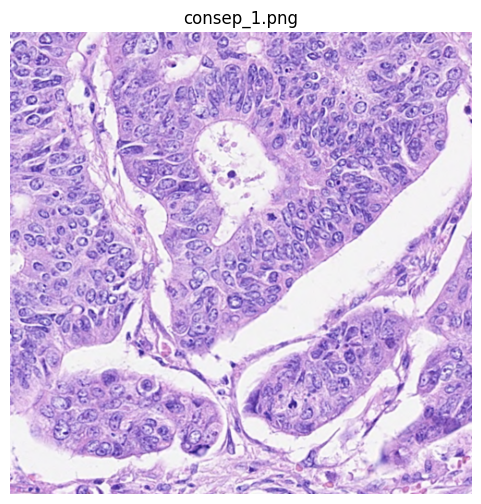

In [106]:
# Show Image

def show_image(path):
    img = np.array(Image.open(path))
    plt.figure(figsize=(6,6))
    plt.title(os.path.basename(path))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


show_image(images1[0])

dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


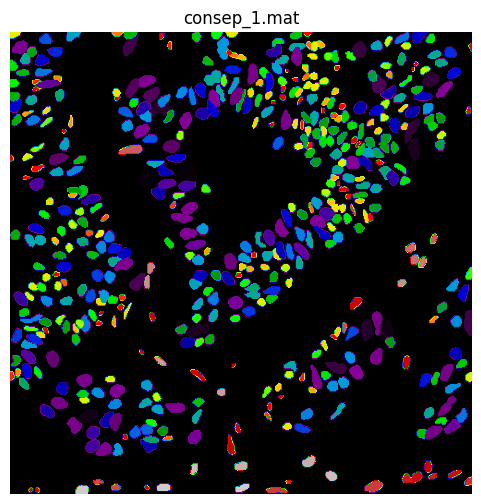

Nuclei in this image: 528


In [103]:
# Show Label

def show_label(path):
    mask_data = sio.loadmat(path)

    print(mask_data.keys())  # see what arrays are inside

    inst_map = mask_data['inst_map']  

    plt.figure(figsize=(6,6))
    plt.imshow(inst_map, cmap='nipy_spectral')
    plt.axis('off')
    plt.title(os.path.basename(path))
    plt.show()

    nuclei_count = len(np.unique(inst_map)) - 1  # subtract 0 (background)
    print("Nuclei in this image:", nuclei_count)


show_label(labels_files[0])

dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


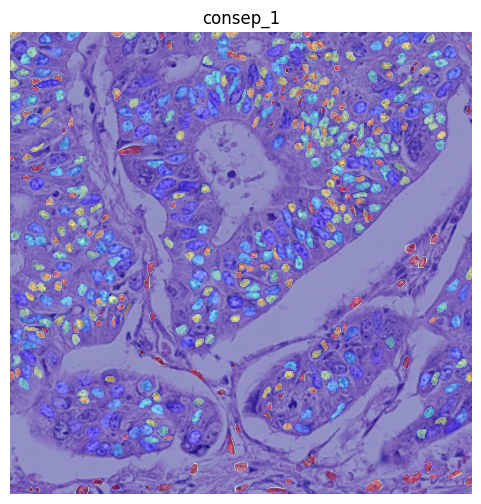

In [107]:
# Overlay Image and Mask

def overlay(img_path, mask_path):
    img = np.array(Image.open(img_path))

    mat = sio.loadmat(mask_path)
    
    print(mat.keys())  # first, to see what key holds your mask
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]  # take first non-meta key
    mask = mat[mask_key]

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='jet')
    plt.title(os.path.basename(img_path).split('.')[0])
    plt.axis('off')
    plt.show()


overlay(images1[0], labels_files[0])


dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


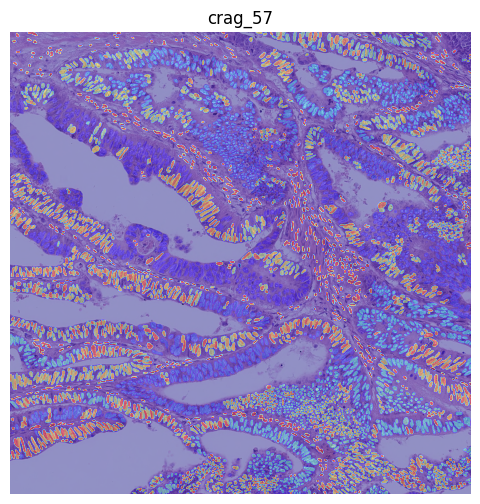

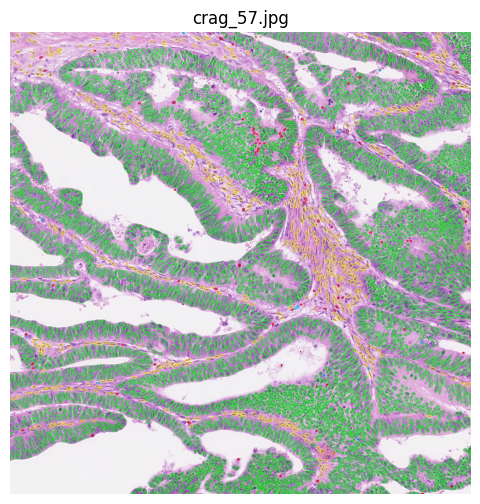

In [114]:
# Overlay random image to check constintancy

random_image = random.choice(images1 + images2)

def get_mask_path(img_path):
    img_name = os.path.basename(img_path).split('.')[0]
    mask_path = os.path.join(LABELS, img_name + ".mat")
    return mask_path

# Image + Label
overlay(random_image, get_mask_path(random_image))

# Overlay from dataset
overlay_img_path = os.path.join(OVERLAY, os.path.basename(random_image).split('.')[0] + ".jpg")
show_image(overlay_img_path)


> I ran this several times and didnt find any inconsistances between overlay files and coresponding combined image + mask

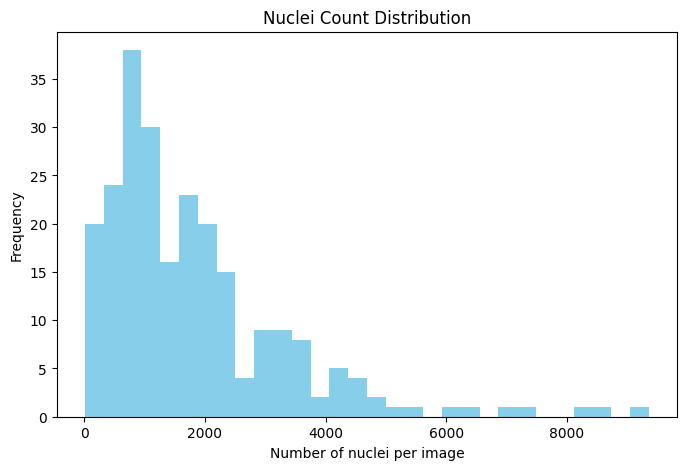

In [86]:
# Number of nuclei per image

nuclei_counts = []
for mask_path in labels_files:
    mat = sio.loadmat(mask_path)
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]
    mask = mat[mask_key]
    count = len(np.unique(mask)) - 1  # subtract background
    nuclei_counts.append(count)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(nuclei_counts, bins=30, color='skyblue')
plt.xlabel("Number of nuclei per image")
plt.ylabel("Frequency")
plt.title("Nuclei Count Distribution")  
plt.show()

> There are some outliers (several images have too many nuclei compared to the others)

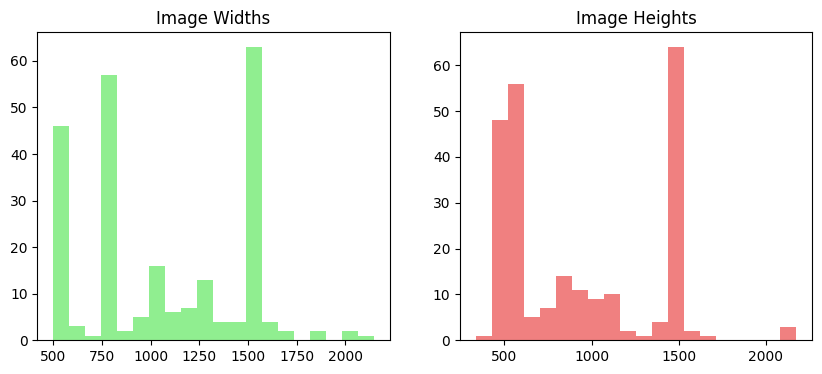

In [94]:
# Image Sizes

img_sizes = [Image.open(p).size for p in images1 + images2]
widths, heights = zip(*img_sizes)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=20, color='lightgreen')
plt.title("Image Widths")

plt.subplot(1,2,2)
plt.hist(heights, bins=20, color='lightcoral')
plt.title("Image Heights")
plt.show()


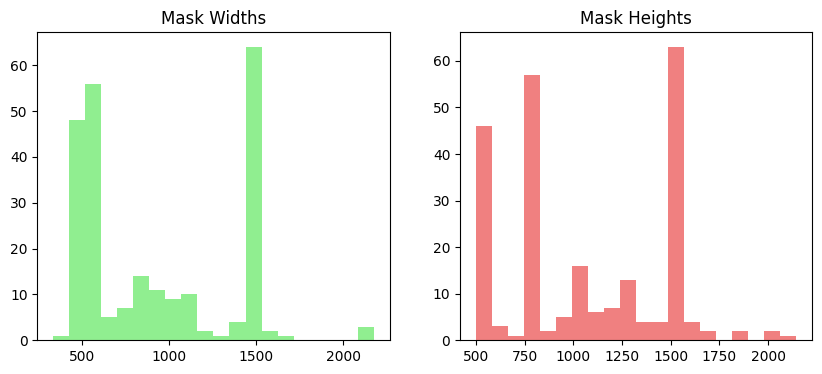

In [95]:
# Mask Sizes

mask_shapes = []
for mask_path in labels_files:
    mat = sio.loadmat(mask_path)
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]
    mask = mat[mask_key]
    mask_shapes.append(mask.shape)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist([s[0] for s in mask_shapes], bins=20, color='lightgreen')
plt.title("Mask Widths")

plt.subplot(1,2,2)
plt.hist([s[1] for s in mask_shapes], bins=20, color='lightcoral')
plt.title("Mask Heights")
plt.show()

> Image sizes differ from one another (needs addressing)